In [15]:
import numpy as np
np.random.seed(1337)
import pandas as pd
import keras
from keras.models import Sequential, Model
from keras import initializers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from sklearn.model_selection import train_test_split
import cv2
import os
import random
from glob import glob
import seaborn as sns
from sklearn.utils import class_weight
from keras import regularizers
from imblearn.over_sampling import RandomOverSampler
from sklearn.externals import joblib
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import applications
import pickle
from keras.models import model_from_json

## Setup (Data Preparation)

In [2]:
# Load npz file containing image arrays
x_npz = np.load("x_images_arrays.npz")
x = x_npz['arr_0']
# Load disease labels
y_npz = np.load("y_disease_labels.npz")
y = y_npz['arr_0']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, stratify=y)

In [4]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3168, 128, 128, 3)
(1359, 128, 128, 3)
(3168,)
(1359,)


In [5]:
X_train_reshape = X_train.reshape(X_train.shape[0], -1).astype('float32')
X_test_reshape = X_test.reshape(X_test.shape[0], -1).astype('float32')

In [6]:
#one-hot encode y_train & y_test
y_trainHot = keras.utils.to_categorical(y_train, 8)
y_testHot = keras.utils.to_categorical(y_test, 8)

In [7]:
epochs=5
# optimizer = optimizers.Adam(lr=0.00003, decay=0.0001)
optimizer = optimizers.SGD(lr=0.003, decay=0.0001, momentum=0.9)
# optimizer= adam
batch_size=100
loss='categorical_crossentropy'
activation='relu'
out_activation='softmax'

In [8]:
tbcallback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, 
                                         write_graph=True, write_images=True)

## Balanced Class Weights

In [32]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
class_weights = dict(enumerate(class_weights))
print(class_weights)
class_weights_df = pd.DataFrame.from_dict(class_weights, orient='index')
class_weights_df

{0: 0.1858984888304862, 1: 7.859375, 2: 1.125, 3: 4.963815789473684, 4: 2.7875615763546797, 5: 3.9296875, 6: 2.947265625, 7: 2.2191176470588236}


,0
0,0.185898
1,7.859375
2,1.125000
3,4.963816
4,2.787562
5,3.929688
6,2.947266
7,2.219118


In [12]:
model = Sequential()
model.add(Dense(150, input_dim=49152, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(125, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(100, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(75, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(50, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(8, activation=out_activation))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
model.load_weights("my_model_weights.h5")
history = model.fit(X_train_reshape, y_trainHot, epochs=25, batch_size=batch_size, 
                    class_weight = class_weights, verbose=1, 
                    validation_data=[X_test_reshape, y_testHot], callbacks=[tbcallback])

Train on 3168 samples, validate on 1359 samples
Epoch 1/25
3168/3168 [==============================] - 90s 28ms/step - loss: 14.0614 - acc: 0.6319 - val_loss: 5.2778 - val_acc: 0.6726
Epoch 2/25
3168/3168 [==============================] - 88s 28ms/step - loss: 14.1339 - acc: 0.6253 - val_loss: 5.2778 - val_acc: 0.6726
Epoch 3/25
3168/3168 [==============================] - 83s 26ms/step - loss: 14.0948 - acc: 0.6288 - val_loss: 5.2778 - val_acc: 0.6726
Epoch 4/25
3168/3168 [==============================] - 77s 24ms/step - loss: 14.1063 - acc: 0.6297 - val_loss: 5.2778 - val_acc: 0.6726
Epoch 5/25
3168/3168 [==============================] - 74s 24ms/step - loss: 14.1605 - acc: 0.6228 - val_loss: 5.2778 - val_acc: 0.6726
Epoch 6/25
3168/3168 [==============================] - 80s 25ms/step - loss: 14.0911 - acc: 0.6316 - val_loss: 5.2778 - val_acc: 0.6726
Epoch 7/25
3168/3168 [==============================] - 77s 24ms/step - loss: 14.1224 - acc: 0.6244 - val_loss: 5.2778 - val_acc: 

1359/1359 [==============================] - 12s 9ms/step
[5.281118400169142, 0.6723484848484849]
[5.277816405447202, 0.6725533483131919]


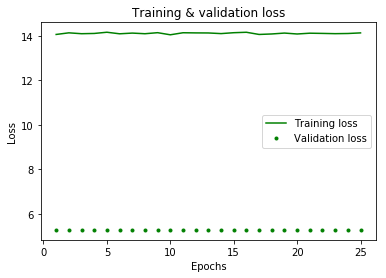

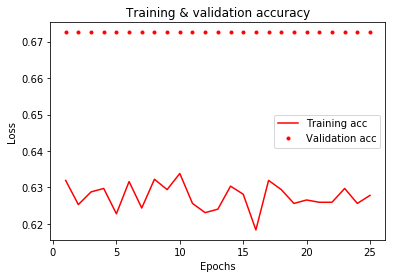

In [14]:
results_train = model.evaluate(X_train_reshape, y_trainHot)
results_test = model.evaluate(X_test_reshape, y_testHot)
print(results_train)
print(results_test)
val_dict = history.history

plt.clf()

loss_values = val_dict['loss']
val_loss_values = val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'g.', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

acc_values = val_dict['acc'] 
val_acc_values = val_dict['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'r.', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# serialize model to JSON
model_json = model.to_json()
with open("balanced_mlp_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("balanced_mlp_model.h5")
print("Saved model to disk")

Saved model to disk


In [20]:
# load json and create model
json_file = open('balanced_mlp_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("balanced_mlp_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [22]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
score = loaded_model.evaluate(X_test_reshape, y_testHot)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

1359/1359 [==============================] - 13s 9ms/step
acc: 67.26%


1359/1359 [==============================] - 13s 10ms/step
[5.281118400169142, 0.6723484848484849]
[5.277816405447202, 0.6725533483131919]


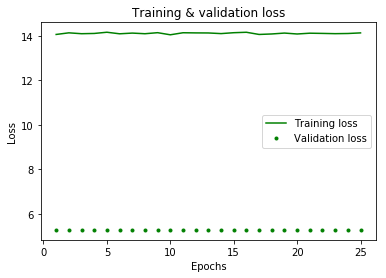

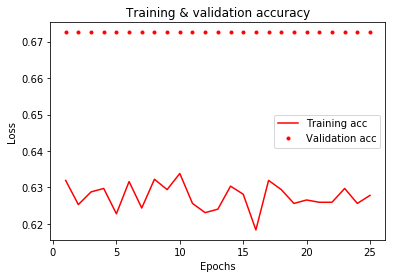

In [23]:
results_train = loaded_model.evaluate(X_train_reshape, y_trainHot)
results_test = loaded_model.evaluate(X_test_reshape, y_testHot)
print(results_train)
print(results_test)
val_dict = history.history

plt.clf()

loss_values = val_dict['loss']
val_loss_values = val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'g.', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

acc_values = val_dict['acc'] 
val_acc_values = val_dict['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'r.', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
model.save_weights('my_model_weights.h5')
joblib.dump(model, 'mlp_balance.pickle')

TypeError: can't pickle _thread.RLock objects

## Random Oversampling

In [24]:
ros = RandomOverSampler(ratio='auto')
X_trainRos, y_trainRos = ros.fit_sample(X_train_reshape, y_train)
X_testRos, y_testRos = ros.fit_sample(X_test_reshape, y_test)

y_trainRosHot = keras.utils.to_categorical(y_trainRos, num_classes = 8)
y_testRosHot = keras.utils.to_categorical(y_testRos, num_classes = 8)

In [25]:
print("X_train: ", X_train.shape)
print("X_trainFlat: ", X_train_reshape.shape)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_testRos Shape: ",X_testRos.shape)
print("Y_trainRosHot Shape: ",y_trainRosHot.shape)
print("Y_testRosHot Shape: ",y_testRosHot.shape)

X_train:  (3168, 128, 128, 3)
X_trainFlat:  (3168, 49152)
X_trainRos Shape:  (17040, 49152)
X_testRos Shape:  (7312, 49152)
Y_trainRosHot Shape:  (17040, 8)
Y_testRosHot Shape:  (7312, 8)


In [26]:
model = Sequential()
model.add(Dense(100, input_dim=49152, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(75, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(10, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(8, activation=out_activation))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
# model.load_weights("my_model_weights_ros.h5")
history = model.fit(X_trainRos, y_trainRosHot, epochs=15, batch_size=batch_size, verbose=1, 
                    validation_data=(X_testRos, y_testRosHot), callbacks=[tbcallback])

Train on 17040 samples, validate on 7312 samples
Epoch 1/15
17040/17040 [==============================] - 297s 17ms/step - loss: 13.8273 - acc: 0.1256 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 2/15
17040/17040 [==============================] - 284s 17ms/step - loss: 13.8537 - acc: 0.1205 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 3/15
17040/17040 [==============================] - 287s 17ms/step - loss: 13.6912 - acc: 0.1259 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 4/15
17040/17040 [==============================] - 290s 17ms/step - loss: 13.5288 - acc: 0.1258 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 5/15
17040/17040 [==============================] - 292s 17ms/step - loss: 13.3521 - acc: 0.1279 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 6/15
17040/17040 [==============================] - 293s 17ms/step - loss: 12.3657 - acc: 0.1249 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 7/15
17040/17040 [==============================] - 272s 16ms/step - loss: 12.2570 - acc: 0.1258 - 

In [27]:
# serialize model to JSON
model_json = model.to_json()
with open("ros_mlp_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("ros_mlp_model.h5")
print("Saved model to disk")

Saved model to disk
